In this notebook, we analyse the impact of C$_\alpha$ vs All-atom representations on the quality of drugs produced. We expect All-atom models to give fewer steric clashes and lesser strain energy for the generated molecules since it has access to the full geometry. 

In [30]:
import MDAnalysis as mda
from MDAnalysis.analysis import align, rms
import os, json, csv, subprocess, re
import pandas as pd
import numpy as np
from pprint import pprint
import matplotlib.pyplot as plt

In [4]:
PATH_1EEI = "test_analysis/combined_1EEI/"
PATH_1EEI_contents = os.listdir(PATH_1EEI)
PATH_1EEI_contents = [path for path in PATH_1EEI_contents if "_bonds" in path]
print (len(PATH_1EEI_contents))

100


In [17]:
LIGAND_RES_THRESH = 10

### Align frame universes

In [13]:
all_frames_universes = {}

for frame_pdb_path in PATH_1EEI_contents:
    full_path = PATH_1EEI + frame_pdb_path
    frame_idx = int(re.findall(r'\d+', frame_pdb_path)[1])
    frame_uni = mda.Universe(full_path, format="PDB")
    all_frames_universes[frame_idx] = frame_uni
    
base_frame = all_frames_universes[0] # get first frame
for frame_idx, frame_uni in all_frames_universes.items():
    if frame_idx != 0:
        align.alignto(frame_uni, base_frame)

Get binding pocket residues

In [18]:
def get_pocket_residues(ligand_atoms, ligand_atom_positions, protein_residues, protein_residue_coms):
    pocket_residues = set()

    for i in range(len(ligand_atoms)):
        atom = ligand_atoms[i]
        atom_xyz = ligand_atom_positions[i]

        for j, res in enumerate(protein_residues):
            if np.linalg.norm(atom_xyz - protein_residue_coms[j]) <= LIGAND_RES_THRESH:
                pocket_residues.add(res)

    pocket_residues = list(pocket_residues)
    return pocket_residues

In [20]:
best_pocket_res_set = None
cur_best_pocket_res_set_len = float('-inf')

for frame_idx, frame_uni in all_frames_universes.items():
    ligand_atoms = frame_uni.select_atoms("resname MOL")
    protein_atoms = frame_uni.select_atoms("protein")
    
    protein_residues = protein_atoms.residues
    protein_residue_coms = [res.atoms.center_of_mass() for res in protein_atoms.residues]    

    pocket_residues = get_pocket_residues(ligand_atoms, ligand_atoms.positions, protein_residues, protein_residue_coms)
    
    if len(pocket_residues) > cur_best_pocket_res_set_len:
        cur_best_pocket_res_set_len = len(pocket_residues)
        best_pocket_res_set = pocket_residues

best_pocket_res_set = list(best_pocket_res_set)
print (best_pocket_res_set)
print (len(best_pocket_res_set))

[<Residue SER, 133>, <Residue LEU, 134>, <Residue ALA, 135>, <Residue GLY, 136>, <Residue LYS, 137>, <Residue ARG, 138>, <Residue GLU, 11>, <Residue TYR, 12>, <Residue HIE, 13>, <Residue ASN, 14>, <Residue THR, 15>, <Residue CYX, 9>, <Residue LEU, 8>, <Residue ALA, 10>, <Residue GLU, 139>, <Residue GLN, 49>, <Residue VAL, 50>, <Residue GLU, 51>, <Residue VAL, 52>, <Residue PRO, 53>, <Residue GLY, 54>, <Residue GLN, 56>, <Residue HIE, 57>, <Residue ILE, 58>, <Residue SER, 60>, <Residue GLN, 61>, <Residue LYS, 62>, <Residue ALA, 64>, <Residue ILE, 65>, <Residue MET, 68>, <Residue CYX, 86>, <Residue VAL, 87>, <Residue TRP, 88>, <Residue ASN, 89>, <Residue ASN, 90>, <Residue LYS, 91>, <Residue THR, 92>, <Residue PRO, 93>, <Residue HIE, 94>, <Residue ALA, 95>, <Residue ILE, 96>, <Residue ALA, 97>]
42


In [49]:
full_atom_mda_query = ""
resolution = "all_atom"
for res in best_pocket_res_set[:-1]:
    if resolution == "all_atom":
        full_atom_mda_query += f"(resid {res.resindex}) or "
    elif resolution == "ca":
        full_atom_mda_query += f"(resid {res.resindex} and name CA) or "
        
if resolution == "all_atom":
    full_atom_mda_query += f"(resid {best_pocket_res_set[-1].resindex})"
elif resolution == "ca":
    full_atom_mda_query += f"(resid {best_pocket_res_set[-1].resindex} and name CA)"
print (full_atom_mda_query)

(resid 132) or (resid 133) or (resid 134) or (resid 135) or (resid 136) or (resid 137) or (resid 10) or (resid 11) or (resid 12) or (resid 13) or (resid 14) or (resid 8) or (resid 7) or (resid 9) or (resid 138) or (resid 48) or (resid 49) or (resid 50) or (resid 51) or (resid 52) or (resid 53) or (resid 55) or (resid 56) or (resid 57) or (resid 59) or (resid 60) or (resid 61) or (resid 63) or (resid 64) or (resid 67) or (resid 85) or (resid 86) or (resid 87) or (resid 88) or (resid 89) or (resid 90) or (resid 91) or (resid 92) or (resid 93) or (resid 94) or (resid 95) or (resid 96)


In [50]:
ca_mda_query = ""
resolution = "ca"
for res in best_pocket_res_set[:-1]:
    if resolution == "all_atom":
        ca_mda_query += f"(resid {res.resindex}) or "
    elif resolution == "ca":
        ca_mda_query += f"(resid {res.resindex} and name CA) or "

if resolution == "all_atom":
    ca_mda_query += f"(resid {best_pocket_res_set[-1].resindex})"
elif resolution == "ca":
    ca_mda_query += f"(resid {best_pocket_res_set[-1].resindex} and name CA)"        
        
print (ca_mda_query)

(resid 132 and name CA) or (resid 133 and name CA) or (resid 134 and name CA) or (resid 135 and name CA) or (resid 136 and name CA) or (resid 137 and name CA) or (resid 10 and name CA) or (resid 11 and name CA) or (resid 12 and name CA) or (resid 13 and name CA) or (resid 14 and name CA) or (resid 8 and name CA) or (resid 7 and name CA) or (resid 9 and name CA) or (resid 138 and name CA) or (resid 48 and name CA) or (resid 49 and name CA) or (resid 50 and name CA) or (resid 51 and name CA) or (resid 52 and name CA) or (resid 53 and name CA) or (resid 55 and name CA) or (resid 56 and name CA) or (resid 57 and name CA) or (resid 59 and name CA) or (resid 60 and name CA) or (resid 61 and name CA) or (resid 63 and name CA) or (resid 64 and name CA) or (resid 67 and name CA) or (resid 85 and name CA) or (resid 86 and name CA) or (resid 87 and name CA) or (resid 88 and name CA) or (resid 89 and name CA) or (resid 90 and name CA) or (resid 91 and name CA) or (resid 92 and name CA) or (resid 9

In [ ]:
bb_noca_mda_query = ""
resolution = "ca"
for res in best_pocket_res_set[:-1]:
    bb_noca_mda_query += f"(resid {res.resindex} and not name CA) or "
bb_noca_mda_query += f"(resid {best_pocket_res_set[-1].resindex})"
print (bb_noca_mda_query)

In [51]:
full_atom_framewise_pocket_rmsd = [(0,0) for _ in range(len(all_frames_universes))]
reference_uni = all_frames_universes[0] # pick first frame
full_atom_ref_pocket = reference_uni.select_atoms(full_atom_mda_query)

for i in range(len(all_frames_universes)):
    if i != 0:
        frame_uni = all_frames_universes[i]
        full_atom_pocket_j = frame_uni.select_atoms(full_atom_mda_query)
        r = rms.rmsd(full_atom_ref_pocket.positions, full_atom_pocket_j.positions, superposition=True, center=True)
        full_atom_framewise_pocket_rmsd[i] = (r, i)

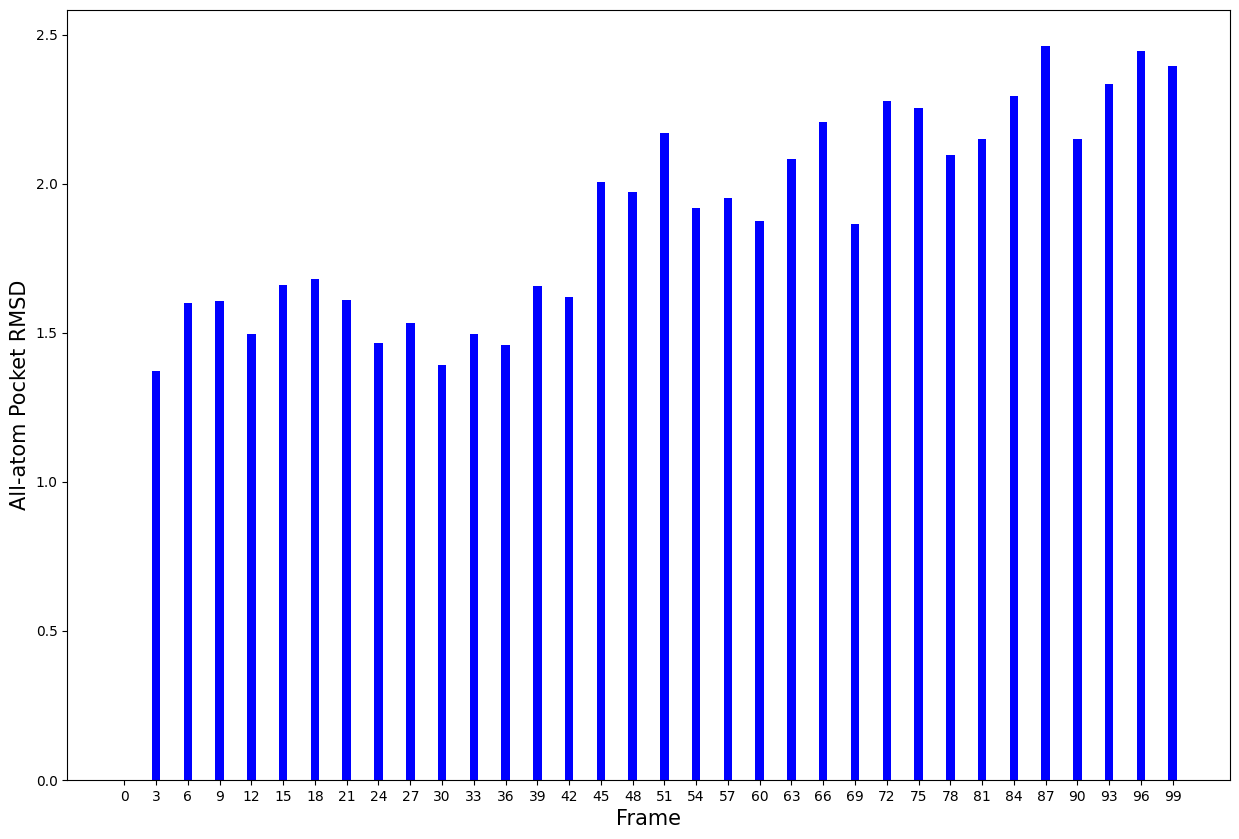

In [52]:
itvl = 3
fig = plt.figure(figsize=(15, 10))
plt.bar(range(len(full_atom_framewise_pocket_rmsd))[::itvl], [rec[0] for rec in full_atom_framewise_pocket_rmsd][::itvl], color="blue")
plt.xticks(range(len(full_atom_framewise_pocket_rmsd))[::itvl], list(map(str, list(range(len(full_atom_framewise_pocket_rmsd)))))[::itvl])
plt.xlabel("Frame", fontsize=15)
plt.ylabel("All-atom Pocket RMSD", fontsize=15)
plt.show()

In [53]:
ca_framewise_pocket_rmsd = [(0,0) for _ in range(len(all_frames_universes))]
reference_uni = all_frames_universes[0] # pick first frame
ca_ref_pocket = reference_uni.select_atoms(ca_mda_query)

for i in range(len(all_frames_universes)):
    if i != 0:
        frame_uni = all_frames_universes[i]
        ca_pocket_j = frame_uni.select_atoms(ca_mda_query)
        r = rms.rmsd(ca_ref_pocket.positions, ca_pocket_j.positions, superposition=True, center=True)
        ca_framewise_pocket_rmsd[i] = (r, i)

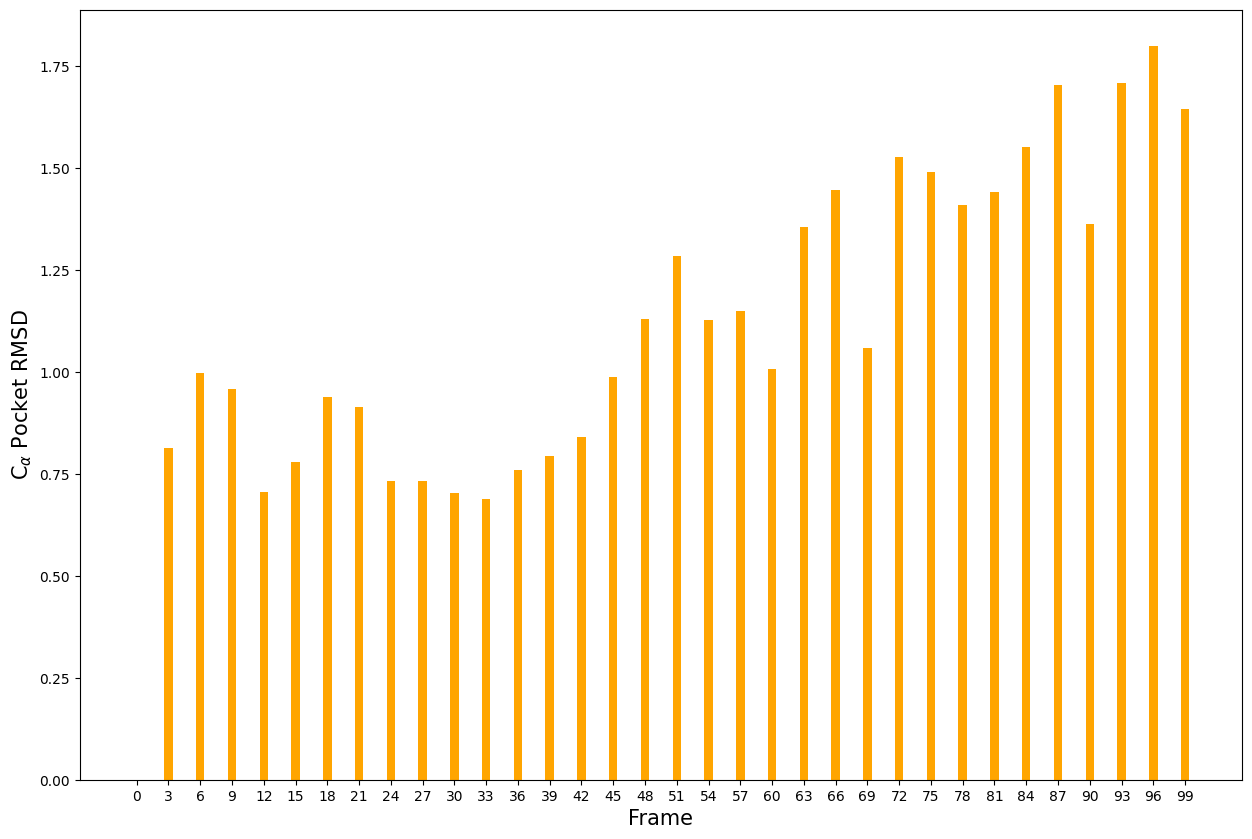

In [54]:
itvl = 3
fig = plt.figure(figsize=(15, 10))
plt.bar(range(len(ca_framewise_pocket_rmsd))[::itvl], [rec[0] for rec in ca_framewise_pocket_rmsd][::itvl], color="orange")
plt.xticks(range(len(ca_framewise_pocket_rmsd))[::itvl], list(map(str, list(range(len(ca_framewise_pocket_rmsd)))))[::itvl])
plt.xlabel("Frame", fontsize=15)
plt.ylabel("C$_\\alpha$ Pocket RMSD", fontsize=15)
plt.show()

Get RMSD between frames when represented using C$_\alpha$ backbone atoms only.

In [ ]:
table = [[0 for _ in range(len(all_frames_universes))] for _ in range(len(all_frames_universes))]

for fid_i, f_uni_i in all_frames_universes.items():
    for fid_j, f_uni_j in all_frames_universes.items():
        if fid_i != fid_j:
            